## THIRD EXPERIMENT

Для третьего эксперимента был использован следующий подход: у нас есть готовая SfM (которую мы получили из 2го эксперимента), при помощи которой мы хотим создать новую SfM с заменой 3д точек. 3D точки были взяты из GT-меша.  Рядом с GT-мешом расположили облако от реконструкции и уронили точки из облака на меш по направлению нормалей меша (ray-casting).

# Libraries


In [16]:
%load_ext autoreload
%autoreload 2
import tqdm, tqdm.notebook
tqdm.tqdm = tqdm.notebook.tqdm  # notebook-friendly progress bars

from pathlib import Path
import pycolmap
import sys

sys.path.append("/workspace/pixel-perfect-sfm/")
sys.path.append("/workspace/pixel-perfect-sfm/Hierarchical-Localization")

from hloc import extract_features, match_features, reconstruction, pairs_from_exhaustive, visualization
from hloc.visualization import plot_images, read_image
from hloc.utils.viz_3d import init_figure, plot_points, plot_reconstruction, plot_camera_colmap
from hloc.utils.read_write_model import  write_next_bytes, Point3D, Image, read_images_text, read_points3D_binary,\
        write_points3D_binary, write_images_binary, read_images_binary, read_cameras_text, read_points3D_text, \
        write_points3D_text, write_images_text

from pixsfm.util.visualize import init_image, plot_points2D
from pixsfm.refine_hloc import PixSfM
from pixsfm import ostream_redirect

import numpy as np
from matplotlib import pyplot as plt

import open3d as o3d
assert o3d.__version__ == '0.15.2', 'The version 0.15.2 is required!'

# redirect the C++ outputs to notebook cells
cpp_out = ostream_redirect(stderr=True, stdout=True)
cpp_out.__enter__()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup

В **object_name** необходимо задать имя объекта, над которым вы хотите провести эксперимент.

**check_for_calibrated_images** - булевая переменная, по которой мы выбираем какие поз камер использовать (менее точные (True) или точные (False))

**delete_previous_output** - если True, то удаляет все предыдущие файлы в папке outputs. Использовать супер осторожно.

In [2]:
object_name = 'dragon'

check_for_calibrated_images = False
delete_previous_output = False

**images_init** - путь к файлу images.txt с известными позами камер (каждая вторая строка пустая)

**calibrated_images_init** - путь к файлу images.txt c известнами позами камер (но менее точные)

**cameras_init** - путь к файлу cameras.txt

**gt_init** - путь к GT-мешу

**images** - путь к папке с изображениями для реконструкции

**outputs** - путь к папке со всеми результатами

**cache_init** - путь к кэш-файлу, его мы получаем во время того, когда делаем KA или BA. В этот файле хранятся featuremaps после dense feature extraction. В среднем на одну картинку размером 2368х1952 уходит 3 минуты. Этот файл вообще нельзя трогать, поэтому мы копируем его в папку outputs для своего эксперимента и продолжаем работу.

**cache_path** - тот же файл, что cache_init, с которым мы теперь будем работать во время эксперимента.

**sfm_pairs** - файл с названиями пар изображений на каждой строке

**features** - файл с features для каждой картинки, извлеченными при помощи feature_conf

**matches** - файл с matches для каждой пары картинок, извлеченными при помощи matcher_conf

In [3]:
root = Path('/workspace')

images_init = root / f'datasets/sk3d/dataset/{object_name}/tis_right/rgb/images.txt'
calibrated_images_init = root / 'datasets/sk3d/dataset/calibration/tis_right/rgb/images.txt' # менее точные

cameras_init = root / 'datasets/sk3d/dataset/calibration/tis_right/rgb/cameras.txt'
gt_init = root / f'datasets/sk3d/dataset/{object_name}/stl/reconstruction/cleaned.ply'

# all images for our object
images = root / f'datasets/sk3d/dataset/{object_name}/tis_right/rgb/undistorted/ambient@best'

# where all result data will be stored
outputs = Path(f'../outputs/{object_name}/')

if delete_previous_output:
    !rm -rf $outputs 

outputs.mkdir(parents=True, exist_ok=True)

sfm_pairs = outputs / 'pairs-sfm.txt'
features = outputs / 'features.h5'
matches = outputs / 'matches.h5'

sfm_dir = outputs / "sfm"
sfm_dir.mkdir(parents=True, exist_ok=True)

exp3_dir = outputs / "exp3"
exp3_dir.mkdir(parents=True, exist_ok=True)


if check_for_calibrated_images:
    images_init = calibrated_images_init

    exp3_dir = outputs / "calibrated/exp3"
    exp3_dir.mkdir(parents=True, exist_ok=True)


**sfm_dir** - папка, в которой хранится реконструкция из второго эксперимента. 

**exp3_dir** - папка, в которой будет сохранен результат третьего эксперимента.

In [4]:
cache_init = root / f'pixel-perfect-sfm/outputs/caches/{object_name}/s2dnet_featuremaps_sparse.h5'
!cp -r $cache_init $outputs
cache_path = outputs / 's2dnet_featuremaps_sparse.h5'

Смотрим саммэри для готовой реконструкции.

In [6]:
sfm_reconstructiom = pycolmap.Reconstruction(sfm_dir)
print("Reconstruction from second experiment: ", sfm_reconstructiom.summary())

Reconstruction from second experiment:  Reconstruction:
	num_reg_images = 100
	num_cameras = 1
	num_points3D = 2494
	num_observations = 45009
	mean_track_length = 18.0469
	mean_observations_per_image = 450.09
	mean_reprojection_error = 1.29788


In [7]:
# get 3d points from our reconstruction
ref_3d_points = {}

# ref_3d_points - dict with keys of points_id and values as points
for point3D_id, point3D in sfm_reconstructiom.points3D.items():
    ref_3d_points.update({point3D_id: list(point3D.xyz)})

In [8]:
# Code to find distance between points and mesh 'path_to_reference_mesh'
vert = list(ref_3d_points.values())

rec = o3d.io.read_triangle_mesh(str(gt_init))
rec.compute_vertex_normals()

raycasting =  o3d.t.geometry.RaycastingScene()
rec = o3d.t.geometry.TriangleMesh.from_legacy(rec)
raycasting.add_triangles(rec)

# pts has shape [pts_n, 3]
pts = o3d.core.Tensor(vert, dtype=o3d.core.Dtype.Float32)
ans = raycasting.compute_closest_points(pts)
closest_pts = raycasting.compute_closest_points(pts)['points'].numpy()

print('The closest point on the surface is', closest_pts)
print('Number of points ',  len(closest_pts))
dist = np.linalg.norm(closest_pts - pts.numpy(), axis=1)
print('Distance between points and mesh ', dist)

The closest point on the surface is [[ 0.02234131  0.01788197  0.69950044]
 [-0.02654355  0.01675105  0.7015435 ]
 [-0.050308    0.04227084  0.67818844]
 ...
 [ 0.03360966  0.03137421  0.67034227]
 [-0.09064084  0.0208866   0.70000476]
 [-0.07028318  0.01878796  0.6946191 ]]
Number of points  2494
Distance between points and mesh  [1.8609574e-04 2.9431682e-04 8.0131441e-02 ... 7.1005215e-06 2.3379524e-03
 2.8307794e-04]


Здесь нужно установить определенный threshold. Мы будем вычислять расстояние между точками и GT-мешом. Если расстояние меньше чем установленный threshold, то эти точки оставляем и записываем в БД, иначе удаляем точки и из меша и в БД. В ланном случае мы выбрали threshold 9 см.

In [9]:
thresh = 0.09

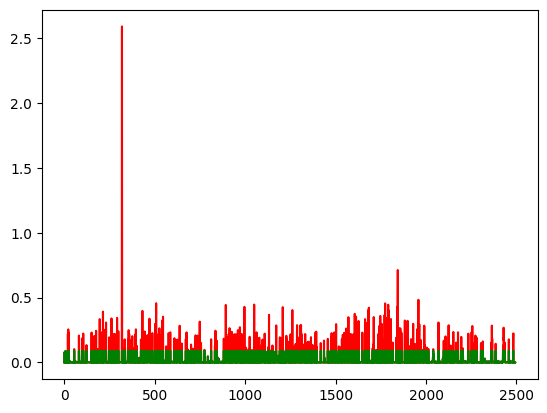

In [10]:
dist_1, dist_2 = [], []

pts_all = []
pts_out_range = []
pts_in_range = []

# vert - vertices from second reconstruction
# pts - corresponding closest points for vert

for i in range(len(vert)):
    dist = np.linalg.norm(closest_pts[i] - pts[i]).numpy()
    dist_1.append(dist)
    pts_all.append(pts[i].numpy())
    if 0 < dist < thresh:
        pts_all[i] = closest_pts[i]
        pts_in_range.append(closest_pts[i])
        
        new_dist = np.linalg.norm(pts_all[i] - pts[i]).numpy()
        dist_2.append(new_dist)
    else:
        pts_out_range.append(pts[i].numpy())
        
        dist_2.append(thresh)
        

plt.plot(dist_1, color='red')
plt.plot(dist_2, color='green')
plt.show()  

Создаем два множества точек: 1) внутри threshold и мы их оставляем   2) за пределами threshold и мы их удаляем. 

In [11]:
points3d_in = {}
points3d_out = {}

for point3D_id, point3D in sfm_reconstructiom.points3D.items():

    query_point = [list(point3D.xyz)]
    pts = o3d.core.Tensor(query_point, dtype=o3d.core.Dtype.Float32)
    ans = raycasting.compute_closest_points(pts)
    closest_pts = raycasting.compute_closest_points(pts)['points'].numpy()
    dist = np.linalg.norm(closest_pts - pts.numpy(), axis=1)
    
    if 0 < dist < thresh:
        points3d_in.update({point3D_id: closest_pts.ravel()})
    else:
        points3d_out.update({point3D_id: point3D.xyz.astype(np.float32)})

Создаем файл point3D.txt

In [14]:
# getting ground truth points from second reconstruction

#gt_points = read_points3D_binary( sfm_dir / 'points3D.bin')
gt_points = read_points3D_text(sfm_dir / 'points3D.txt')

points3D = {}

# updating gt_points
for key, value in points3d_in.items():
    if (gt_points[key].xyz != value).all():
        point3D_id = gt_points[key].id
        
        # putting new value here
        xyz = value 
        rgb = gt_points[key].rgb
        error = gt_points[key].error
        image_ids_ = gt_points[key].image_ids
        point2D_idxs = gt_points[key].point2D_idxs
        points3D[point3D_id] = Point3D(id=point3D_id, 
                                       xyz=xyz, 
                                       rgb=rgb,
                                       error=error, 
                                       image_ids=image_ids_,
                                       point2D_idxs=point2D_idxs)


# write_points3D_binary(points3D, exp3_dir / 'points3D.bin')    
write_points3D_text(points3D, exp3_dir / 'points3D.txt')  

Создаем файл images.txt

In [17]:
#images_dict = read_images_binary( sfm_dir / 'images.bin')
images_dict = read_images_text( sfm_dir / 'images.txt')

updated_images_dict = {}


pts_to_delete = points3d_out.keys()

#updating images dictionary
for k, value in images_dict.items():
    new_point3D_ids = []
    image_id = k
    qvec = value.qvec
    tvec = value.tvec
    camera_id = value.camera_id
    name = value.name
    xys = value.xys
      
    # we need to put -1 for images.txt, because we will not have these points anymore    
    for _id in value.point3D_ids:
        if _id in pts_to_delete:
            new_point3D_ids.append(-1)
        else:
            new_point3D_ids.append(_id)

    updated_images_dict[image_id] = Image(
                id=image_id, 
                qvec=qvec, tvec=tvec,
                camera_id=camera_id, 
                name=name,
                xys=xys, 
                point3D_ids=np.array(new_point3D_ids))

# write_images_binary(updated_images_dict, exp3_dir / 'images.bin')    
write_images_text(updated_images_dict, exp3_dir / 'images.txt')    

Копируем cameras.txt из предыдущего эксперимента.

In [18]:
!cp -r $sfm_dir/cameras.txt $exp3_dir

**Featuremetric BA (Bundle Adjustment)**

В конфиге conf_BA расписана необходимая информация для того, чтобы сделать BA. В этом конфиге также указано, что вы хотите использовать cache, который находится в пути cache_path.

Здесь описано как настроить конфигурацию для ВА. https://github.com/cvg/pixel-perfect-sfm#detailed-configuration


In [19]:
from pixsfm.refine_colmap import PixSfM

conf_BA = {
        "dense_features": {
                "use_cache": True,
        },
        
        "BA": {
            "dense_features": {'use_cache': True}, 
            "apply": True
        }
}

refiner = PixSfM(conf=conf_BA)
reconstruction, ba_data, feature_manager = refiner.refine_reconstruction(
    output_path = exp3_dir / f'thresh_{thresh}',
    input_path = exp3_dir,
    image_dir = images,
    cache_path = cache_path,
)

print(reconstruction.summary())

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
[2022/09/20 03:46:59 pixsfm.features.models.s2dnet INFO] Loading S2DNet checkpoint at /workspace/pixel-perfect-sfm/pixsfm/features/models/checkpoints/s2dnet_weights.pth.
[2022/09/20 03:46:59 pixsfm INFO] Loaded dense extractor with configuration:
{'cache_format': 'chunked',
 'device': 'auto',
 'dtype': 'half',
 'fast_image_load': False,
 'l2_normalize': True,
 'load_cache_on_init': False,
 'max_edge': 1600,
 'model': {'name': 's2dnet'},
 'overwrite_cache': False,
 'patch_size': 16,
 'pyr_scales': [

[2022/09/20 03:47:00 pixsfm INFO] Loading featuremaps from H5 File.


100%[████████████████████] 100/100 [00:00, 699.300it/s]


[2022/09/20 03:47:00 pixsfm INFO] Loading patches from H5 File.


100%[████████████████████] 39275/39275 [00:01, 29821.5it/s]


[2022/09/20 03:47:01 pixsfm INFO] Extracting references.


100%[████████████████████] 2181/2181 [00:02, 840.138it/s]


[2022/09/20 03:47:04 pixsfm INFO] Reference Extraction Time: 2.59682s
[2022/09/20 03:47:04 pixsfm INFO] Start feature-reference bundle adjustment.


100%[████████████████████] 101/101 [00:45, 2.21758it/s]


[2022/09/20 03:47:50 pixsfm INFO] BA Time: 45.5529s, cost change: 0.0194269 --> 0.0191479
Reconstruction:
	num_reg_images = 100
	num_cameras = 1
	num_points3D = 2181
	num_observations = 39275
	mean_track_length = 18.0078
	mean_observations_per_image = 392.75
	mean_reprojection_error = 1.3587


Перевод модели в формат TXT.

In [20]:
!mkdir -p $exp3_dir/thresh_$thresh/model_txt/ 

!colmap model_converter \
    --input_path $exp3_dir/thresh_$thresh/ \
    --output_path $exp3_dir/thresh_$thresh/model_txt/ \
    --output_type TXT